In [1]:
import pandas as pd
import numpy as np 
import re
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
import pickle
import time

In [4]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

In [3]:
#Open Corpus of News Article Text
with open('./data/news_data_frame_reduced_preprocessed.pickle', 'rb') as file:
    news_df = pickle.load(file)

In [5]:
# Convert text and response to array 
y_response = news_df.Not_Real_or_Real.values

In [6]:
fileObject = open("./data/grams/trigram_text",'rb')  
tri_lem_comb2 = pickle.load(fileObject)  ## load unigram

In [7]:
%%time
tfidf = TfidfVectorizer(min_df = 0.001, max_df = 0.75)
text_tfidf = tfidf.fit_transform(tri_lem_comb2)

CPU times: user 3.03 s, sys: 79.3 ms, total: 3.1 s
Wall time: 4.05 s


In [8]:
type(text_tfidf)

scipy.sparse.csr.csr_matrix

In [9]:
%%time
dense_text = text_tfidf.todense()

CPU times: user 239 ms, sys: 1.09 s, total: 1.33 s
Wall time: 1.64 s


In [10]:
type(dense_text)

numpy.matrixlib.defmatrix.matrix

In [11]:
dense_text2 = np.squeeze(np.asarray(dense_text))

In [12]:
dense_text2[0:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [13]:
# Get list of all words in tfidf vocabulary
features = tfidf.get_feature_names()

In [14]:
len(features)

31674

In [15]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [16]:
def top_overall_words(text, response, features, cls=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in ids. '''
    if cls:
        ids = np.where(response == cls)
        D = text[ids]
    else:
        D = text

    D[D < min_tfidf] = 0 # so common words across all documents won't dominate - may remove
    tfidf_mean = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_mean, features, top_n)

In [17]:
dense_text2.shape

(4426, 31674)

In [18]:
%%time
# real news top 25
real_top_wd = top_overall_words(dense_text2, y_response, features, cls = 0)

CPU times: user 831 ms, sys: 469 ms, total: 1.3 s
Wall time: 1.79 s


In [19]:
%%time
# fake news top 25
fake_top_wd = top_overall_words(dense_text2, y_response, features, cls = 1)

CPU times: user 535 ms, sys: 1.16 s, total: 1.69 s
Wall time: 2.36 s


In [20]:
real_top_wd[0:10]

,feature,tfidf
0,trump,0.018419
1,said,0.011194
2,terms_service_cookie_policy,0.007908
3,blocking_loading_information_review,0.007908
4,browser_supports_javascript_cookies,0.007908
5,happen_please_make_sure,0.007908
6,iran,0.006432
7,clinton,0.005267
8,china,0.004880
9,huawei,0.004718


In [21]:
fake_top_wd[0:10]

,feature,tfidf
0,trump,0.019811
1,clinton,0.011038
2,russia,0.007397
3,hillary,0.007308
4,fbi,0.006387
5,isis,0.006168
6,hillary_clinton,0.006153
7,obama,0.005886
8,vote,0.005685
9,syria,0.005684


<Figure size 864x432 with 0 Axes>

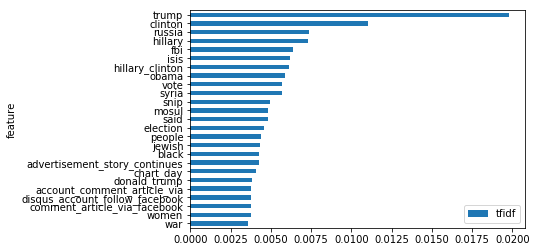

In [22]:
plt.figure(figsize=(12,6))
fake_top_wd.sort_values(by = 'tfidf', ascending=True).plot.barh(x ='feature')

<Figure size 864x432 with 0 Axes>

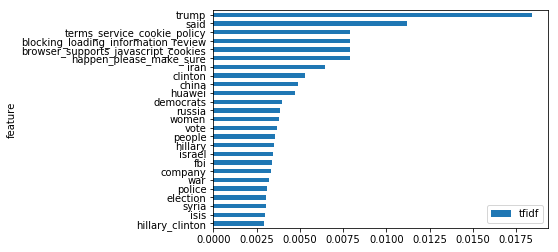

In [23]:
plt.figure(figsize=(12,6))
real_top_wd.sort_values(by = 'tfidf', ascending=True).plot.barh(x ='feature')

In [24]:
fileObject = open("./data/grams/token_unigram_text",'rb')
uni_lem = pickle.load(fileObject)  

In [25]:
uni_lem.shape

(4426,)

In [26]:
print(credible_news_df_preprocessed.shape)
print(not_credible_news_df_preprocessed.shape)

NameError: name 'credible_news_df_preprocessed' is not defined

In [27]:
13134+1798

14932

In [28]:
fileObject.close()

In [29]:
real = uni_lem[0:1798]
fake = uni_lem[1798: ]

In [30]:
len(real)

1798

In [31]:
len(fake)

2628

In [32]:
real_list = [item for sublist in real for item in sublist]

In [33]:
fake_list = [item for sublist in fake for item in sublist]

In [34]:
fake_dict = Counter(fake_list)
real_dict = Counter(real_list)

In [35]:
word_count = pd.DataFrame([fake_dict, real_dict]).T

In [36]:
word_count.sample(n=10, random_state=1)

,0,1
elsewherecuba,NaN,1.0
radial,1.0,NaN
techlash,1.0,NaN
madonnas,NaN,1.0
mazie,NaN,2.0
khan,41.0,5.0
avers,NaN,3.0
spectacles,2.0,NaN
transatlantico,2.0,NaN
flurry,12.0,17.0


In [37]:
word_count = word_count.fillna(0)

In [38]:
word_count.columns = ['fake', 'real']

In [39]:
word_count['fakepct'] = word_count['fake'].apply(lambda x: x / len(fake))
word_count['realpct'] = word_count['real'].apply(lambda x: x /len(real))

In [40]:
word_count['fakepct'] = word_count['fakepct'].apply(lambda x: x + 1)
word_count['realpct'] = word_count['realpct'].apply(lambda x: x + 1)

In [41]:
word_count['fake2real'] = word_count['fakepct'] / word_count['realpct']
word_count['real2fake'] = word_count['realpct'] / word_count['fakepct']

# Most Fake Words

In [42]:
word_count.sort_values("fake2real", ascending = False).head(20)

,fake,real,fakepct,realpct,fake2real,real2fake
clinton,3352.0,90.0,2.275495,1.050056,2.167023,0.461463
hillary,1982.0,45.0,1.754186,1.025028,1.711354,0.584333
obama,1364.0,159.0,1.519026,1.088432,1.395610,0.716533
black,1379.0,367.0,1.524734,1.204116,1.266268,0.789722
clintons,673.0,15.0,1.256088,1.008343,1.245696,0.802764
election,1900.0,705.0,1.722983,1.392102,1.237684,0.807960
russia,1162.0,345.0,1.442161,1.191880,1.209989,0.826454
syrian,599.0,44.0,1.227930,1.024472,1.198598,0.834308
syria,972.0,261.0,1.369863,1.145161,1.196218,0.835968
email,856.0,205.0,1.325723,1.114016,1.190040,0.840308


# Most Real Words

In [43]:
word_count.sort_values("real2fake", ascending = False).head(20)

,fake,real,fakepct,realpct,fake2real,real2fake
said,4603.0,6850.0,2.751522,4.809789,0.572067,1.748047
iran,475.0,1301.0,1.180746,1.723582,0.685054,1.459740
huawei,123.0,885.0,1.046804,1.492214,0.701511,1.425495
think,1406.0,2119.0,1.535008,2.178532,0.704607,1.419232
companies,438.0,1143.0,1.166667,1.635706,0.713249,1.402034
yeah,150.0,781.0,1.057078,1.434372,0.736962,1.356922
china,604.0,1186.0,1.229833,1.659622,0.741032,1.349470
getty,345.0,943.0,1.131279,1.524472,0.742079,1.347565
house,1259.0,1781.0,1.479072,1.990545,0.743049,1.345807
thats,791.0,1329.0,1.300989,1.739155,0.748058,1.336794


# Most Frequent Fake Words

In [44]:
word_count.sort_values("real", ascending = False).head(20)

,fake,real,fakepct,realpct,fake2real,real2fake
said,4603.0,6850.0,2.751522,4.809789,0.572067,1.748047
one,4309.0,3875.0,2.639650,3.155172,0.836610,1.195300
trump,5201.0,3749.0,2.979072,3.085095,0.965634,1.035589
would,3890.0,3432.0,2.480213,2.908788,0.852662,1.172797
people,4422.0,3383.0,2.682648,2.881535,0.930979,1.074138
like,2613.0,2911.0,1.994292,2.619021,0.761465,1.313258
new,2907.0,2665.0,2.106164,2.482202,0.848506,1.178542
also,2809.0,2487.0,2.068874,2.383204,0.868106,1.151933
time,2462.0,2309.0,1.936834,2.284205,0.847925,1.179350
president,2413.0,2187.0,1.918189,2.216352,0.865471,1.155440


# Most Frequent Real Words

In [45]:
word_count.sort_values("fake", ascending = False).head(20)

,fake,real,fakepct,realpct,fake2real,real2fake
trump,5201.0,3749.0,2.979072,3.085095,0.965634,1.035589
said,4603.0,6850.0,2.751522,4.809789,0.572067,1.748047
people,4422.0,3383.0,2.682648,2.881535,0.930979,1.074138
one,4309.0,3875.0,2.639650,3.155172,0.836610,1.195300
would,3890.0,3432.0,2.480213,2.908788,0.852662,1.172797
clinton,3352.0,90.0,2.275495,1.050056,2.167023,0.461463
new,2907.0,2665.0,2.106164,2.482202,0.848506,1.178542
also,2809.0,2487.0,2.068874,2.383204,0.868106,1.151933
like,2613.0,2911.0,1.994292,2.619021,0.761465,1.313258
time,2462.0,2309.0,1.936834,2.284205,0.847925,1.179350


In [46]:
real_extracted = real.apply(lambda x: ' '.join(x))
fake_extracted = real.apply(lambda x: ' '.join(x))

In [47]:
cv = CountVectorizer()
cv2 = CountVectorizer()

real_cv = cv.fit_transform(real_extracted)
fake_cv = cv2.fit_transform(fake_extracted)

In [48]:
cv.vocabulary_

{'ban': 2527,
 'united': 35231,
 'states': 31791,
 'companies': 6471,
 'selling': 29783,
 'parts': 24243,
 'huawei': 15695,
 'take': 33029,
 'effect': 10337,
 'friday': 13012,
 'commerce': 6419,
 'secretary': 29663,
 'said': 28947,
 'wilbur': 36839,
 'ross': 28630,
 'told': 33959,
 'bloomberg': 3536,
 'news': 22569,
 'agency': 612,
 'thursday': 33762,
 'new': 22551,
 'regulations': 27503,
 'bar': 2579,
 'acquiring': 274,
 'components': 6570,
 'technology': 33282,
 'firms': 12357,
 'without': 37002,
 'government': 13951,
 'approval': 1567,
 'technologies': 33280,
 'ltd': 19718,
 'affiliates': 547,
 'added': 338,
 'department': 8631,
 'entity': 10911,
 'list': 19386,
 'move': 21901,
 'makes': 20051,
 'difficult': 9039,
 'impossible': 16224,
 'firm': 12350,
 'sell': 29778,
 'certain': 5283,
 'products': 26004,
 'due': 10004,
 'reliance': 27610,
 'suppliers': 32615,
 'statement': 31787,
 'wednesday': 36553,
 'president': 25805,
 'donald': 9652,
 'trump': 34574,
 'sought': 31198,
 'prevent'

In [49]:
text_tfidf[0]

<1x31674 sparse matrix of type '<class 'numpy.float64'>'
	with 261 stored elements in Compressed Sparse Row format>

In [50]:
dense_text = text_tfidf.todense()

In [51]:
from sklearn.datasets import dump_svmlight_file
from sklearn.datasets import load_svmlight_file
dump_svmlight_file(text_tfidf, y_response, './data/tfidf.dat')

In [52]:
data = load_svmlight_file('./data/tfidf.dat')

In [53]:
def get_data():
    data = load_svmlight_file('./data/tfidf.dat')
    return data[0], data[1]

X, y = get_data()

In [54]:
X.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [55]:
# Get list of all words in tfidf vocabulary
features = tfidf.get_feature_names()

In [56]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [57]:
def top_overall_words(text, response, features, cls=None, min_tfidf=0.1, top_n=25):
    ''' Return the top n features that on average are most important amongst documents in rows
        indentified by indices in ids. '''
    if cls:
        ids = np.where(response == cls)
        D = text[ids].toarray()
    else:
        D = text.toarray()

    D[D < min_tfidf] = 0 # so common words across all documents won't dominate - may remove
    tfidf_mean = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_mean, features, top_n)

In [58]:
top_overall_words(text_tfidf, y_response, features)

,feature,tfidf
0,trump,0.018419
1,said,0.011194
2,terms_service_cookie_policy,0.007908
3,blocking_loading_information_review,0.007908
4,browser_supports_javascript_cookies,0.007908
5,happen_please_make_sure,0.007908
6,iran,0.006432
7,clinton,0.005267
8,china,0.004880
9,huawei,0.004718
